In [3]:
#install pacakges once and for all
!pip install pyhive pydeck python-geohash pyquadkey2 h3 shapely==1.8 keplergl seaborn --user -q -q

In [3]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

In [4]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
from keplergl import KeplerGl
import os
from pyhive import trino
import pydeck as pdk
os.environ['MAPBOX_API_KEY'] = "INSERT YOUR MAPBOX TOKEN HERE"

In [5]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [4]:
%%sql
show catalogs

 * trino://localhost:9090/cuebiq/
Done.


,Catalog
0,cuebiq
1,dedicated


In [5]:
%%sql
show schemas from cuebiq

 * trino://localhost:9090/cuebiq/
Done.


,Schema
0,paas_cda_pe_v3
1,paas_public_data
2,vehicle_v1


In [18]:
%sql show tables from cuebiq.paas_public_data

 * trino://localhost:9090/cuebiq/
Done.


,Table
0,census_data
1,census_taxonomy
2,us_census_tiger_place


In [17]:
%sql show tables from cuebiq.paas_cda_pe_v3
# %sql show tables from dedicated.rsu

 * trino://localhost:9090/cuebiq/
Done.


,Table
0,brand
1,cbsa
2,custom_poi
3,custom_poi_history
4,device_location_uplevelled
5,device_metrics_uplevelled
6,device_recurring_area
7,device_user_labeling
8,geography_registry
9,poi


In [7]:
sql_engine.read_sql(f"desc cuebiq.paas_public_data.census_taxonomy")

,Column,Type,Extra,Comment
0,statefp,varchar,,
1,placefp,varchar,,
2,placens,varchar,,
3,geoid,varchar,,
4,name,varchar,,
5,namelsad,varchar,,
6,lsad,varchar,,
7,classfp,varchar,,
8,pcicbsa,varchar,,
9,pcinecta,varchar,,


In [7]:
schema_name = {'cda': 'cuebiq.paas_cda_pe_v3'}
stop_table = f"{schema_name['cda']}.stop_uplevelled"
newtable_name = f"dedicated.rsu.la_stop_uplevelled"

In [10]:
# %sql create table if not exists $newtable_name as select * from {stop_table} WITH NO DATA

 * trino://localhost:9090/cuebiq/
0 rows affected.


,rows
0,0


In [8]:
%sql show tables from dedicated.rsu

 * trino://localhost:9090/cuebiq/
Done.


,Table
0,la_stop_uplevelled
1,new_table_demo


# Select a specific date and subset stop table and write to a new table

In [9]:
date = 20220310 # Thursday: According to Toger et al. (2020) , Thursday is the most “regular” weekday with the lowest variance in human mobility behaviour, compared to other days of the week.
date_formated = datetime.strptime(str(date), "%Y%m%d").strftime("%Y-%m-%d")
date_plus = int((datetime.strptime(str(date), "%Y%m%d") + timedelta(days=3)).strftime("%Y%m%d"))# You see that we can limit to the first three processing dates starting from the local date of interest.

la_stop_query = f"""
    select * 
    from {stop_table}
    where 
        country_code = 'US'
        and admin2_id = 'US.CA.037'
        and provider_id = '190199'
        and processing_date between {date} and {date_plus}
        and substr(stop_zoned_datetime,1,10) = '{date_formated}'
    """

In [10]:
%%time
%sql insert into $newtable_name ($la_stop_query)

 * trino://localhost:9090/cuebiq/
1202870 rows affected.


,rows
0,1202870


In [12]:
%sql SELECT COUNT(*) FROM $newtable_name 

 * trino://localhost:9090/cuebiq/
Done.


,_col0
0,2355148


CPU times: user 157 ms, sys: 28.1 ms, total: 185 ms
Wall time: 4.42 s


Text(0, 0.5, 'count')

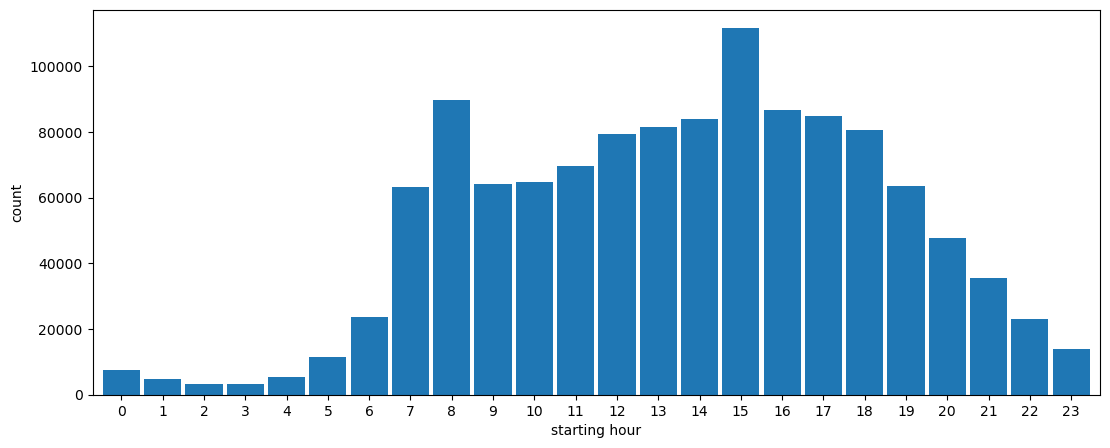

In [15]:
%%time

df_by_hour = sql_engine.read_sql(
    f"""
    select 
        cast(hour(from_iso8601_timestamp(stop_zoned_datetime)) as int) as hour,
        count(*) as cnt
    from {newtable_name}
    where 
        substr(stop_zoned_datetime,1,10) = '{date_formated}'
    group by 1
    order by 1
    """
)

plt.figure(figsize=(13,5))
df_by_hour.set_index('hour').cnt.plot.bar(width=0.9)
plt.xticks(rotation=0)
plt.xlabel('starting hour')
plt.ylabel('count');

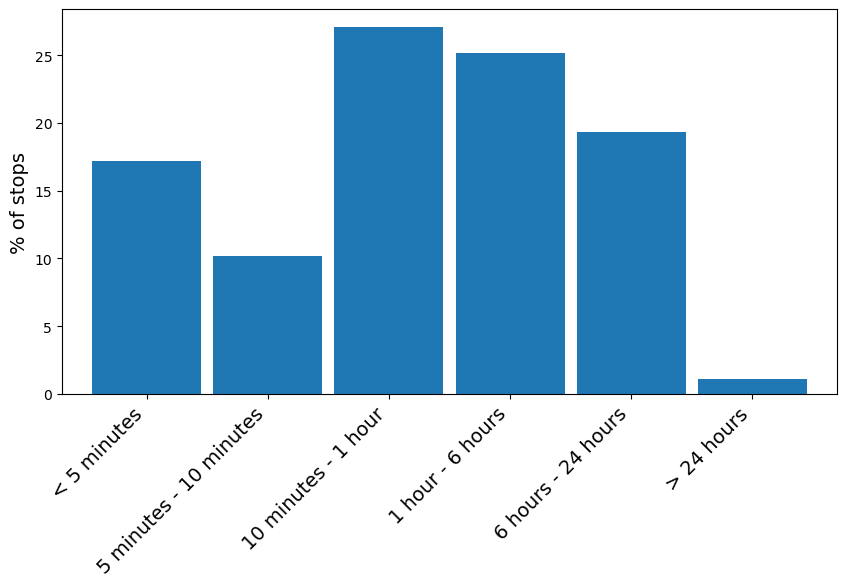

In [16]:
df_by_dwell_time = sql_engine.read_sql(
    f"""
    select 
        count_if(dwell_time_minutes < 5) as "< 5 minutes",
        count_if(dwell_time_minutes between 5 and 10-1) as "5 minutes - 10 minutes",
        count_if(dwell_time_minutes between 10 and 60-1) as "10 minutes - 1 hour",
        count_if(dwell_time_minutes between 60 and 60*6 - 1) as "1 hour - 6 hours",
        count_if(dwell_time_minutes between 60*6 - 1 and 1440-1) as "6 hours - 24 hours",
        count_if(dwell_time_minutes >= 1440) as "> 24 hours"
    from {newtable_name}
    where 
        substr(stop_zoned_datetime,1,10) = '{date_formated}'
    """
).T[0]

plt.figure(figsize=(10,5))
(100 * df_by_dwell_time / df_by_dwell_time.sum()).plot.bar(width=0.9)

# -- ticks and labels
plt.xticks(rotation=45, fontsize=14, ha='right')
plt.ylabel('% of stops', fontsize=14);
plt.show()